In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

In [4]:
from stockmarket import Market
from market_instance import Stock, GeoMarket, Segment
from environment import TradingEnvironment
import pickle
from trading_model import MarketEnvironment, Observation, StockMarket, MarketFromData
from statsutils import avg_over_axis

In [5]:
N_STOCKS = 10

In [6]:
tickers = list(set(["".join([chr(int(np.random.random()*26+65)) for i in range(4)]) 
                    for i in range(2*N_STOCKS)]))[:N_STOCKS]
tickers

['DIBQ',
 'GFYG',
 'ZUXU',
 'EHZF',
 'WDBY',
 'DZRD',
 'VVJE',
 'DAYZ',
 'BAZB',
 'OWNV']

In [58]:
def plot_many(rows, cols, width, height, data=None, titles=None, xlim=None):
    fig, plots = plt.subplots(rows,cols)
    fig.set_figheight(height)
    fig.set_figwidth(width)  
    
    if data is not None:
        for p, d in zip(plots, data):
            for c in d:
                p.plot(*c)
    if titles is not None:
        for p, c in zip(plots, titles):
            p.set_title(c)
    if xlim is not None:
        for p in plots:
            p.set_xlim(xlim)
    return plots

# A Synthetic Market
Our synthetic market features a year with 256 trading days, that's four quarters of 64 trading days each. 

### Sentiments 
Sentiments are modeled as simple multipliers to the fundamental value of a stock. These multipliers basically come in the form of discontinuous sections of linear values in time. The discontuity stems from earnings surprises and other random events. ```rnd_sentiments``` provides some random parameters for these sections. Each quarter has its own linear section.

Stocks will inhibit a feature (method) called $\phi(t)$ that explicitly models the sentiment over time as we will see two cells from now.

In [111]:
def rnd_sentiments(s_max = 1, s_min = -10, n_quarters = 16):
    s_c = 0
    q = 64 # a quarter
    s = {0: (0, 0)}
    for i in range(n_quarters):
        dst = np.random.normal(.002, .005) / q
        day = i * q + int(np.random.normal(5))
        s[day] = (s_c, dst)
        s_c = min(s_max, s_c + np.random.normal(0, .005))
        s_c = max(s_min, s_c)
    s[1024] = (0,0)
    return s
#rnd_sentiments()

#### Geo market and segment influences (not really used yet)

In [123]:
# US market: bulls and bears
us = GeoMarket('US',                   # A name
               {0: (.1,0.001),         # Market sentiment over time, starting slightly bullish
                300: (-.1, 0),         # Not too bad yet
                400: (.2, -0.005),     # A period of hope
                500: (.3, 0),          # And more hope
                700: (.1, 0.001)})    # Not really getting better.

# Segment sentiment: IT is calming down - the dawn of the new AI winter?
it = Segment('Information Technology', {0: (.0, .001)})

#### The stocks 
```psi(t)```, or $\Psi(t)$ is the *Expectation of the perceived value*. 

In [128]:
duration=1024
stocks = []
for ticker in tickers:
    E_cagr = np.random.normal(3e-2, 2e-2)   # expected compound annual growth rate
    max_effect = 3.0 # Maximum overrating due to sentiment
    psi0 = 50 + 20 * np.random.random() # initial price
    sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
    beta_geo = np.random.normal(.0, .2)       # exposure (beta) to the US market
    beta_it = np.random.normal(.2, .4)       # exposure (beta) to the IT sector
    stock = Stock(name=ticker, E_cagr=E_cagr, max_effect=max_effect, psi0 = psi0,
                    segments = {it: beta_it}, markets = {us: beta_geo},
                    sentiments = sentiments, noise=.4)
    stocks.append(stock)

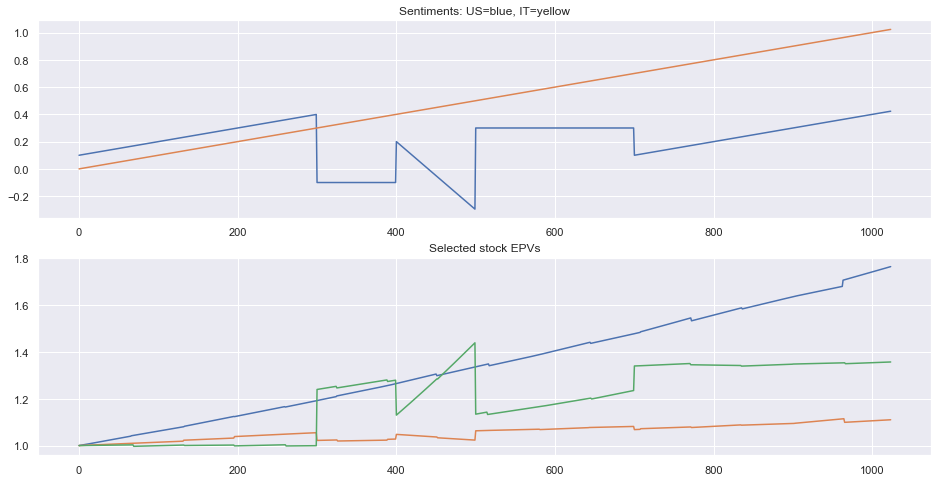

In [129]:
plot_many(2,1, 16, 8, data=[
    [
            [[us.phi(t) for t in range(duration)]],
            [[it.phi(t) for t in range(duration)]]
    ],
    [
            [[stocks[i].psi(t)/stocks[i].psi(0) for t in range(duration)]] 
        for i in [1,2,3]
    ]
], titles=["Sentiments: US=blue, IT=yellow", 'Selected stock EPVs']);

#### Generating market history

In [130]:
period=1024
market = Market(stocks=stocks, bid_ask=0.1)

config = {
    'num_investors': 10,
    'num_rounds_per_day': 5
}

holdings = {ticker: 10000 for ticker in tickers}
holdings['cash'] = 1e8

environment = TradingEnvironment(config, holdings, market, tx_cost=2.5e-3)

for _ in range(period):
    market.open()
    daily = environment.let_others_trade()
    market.close()


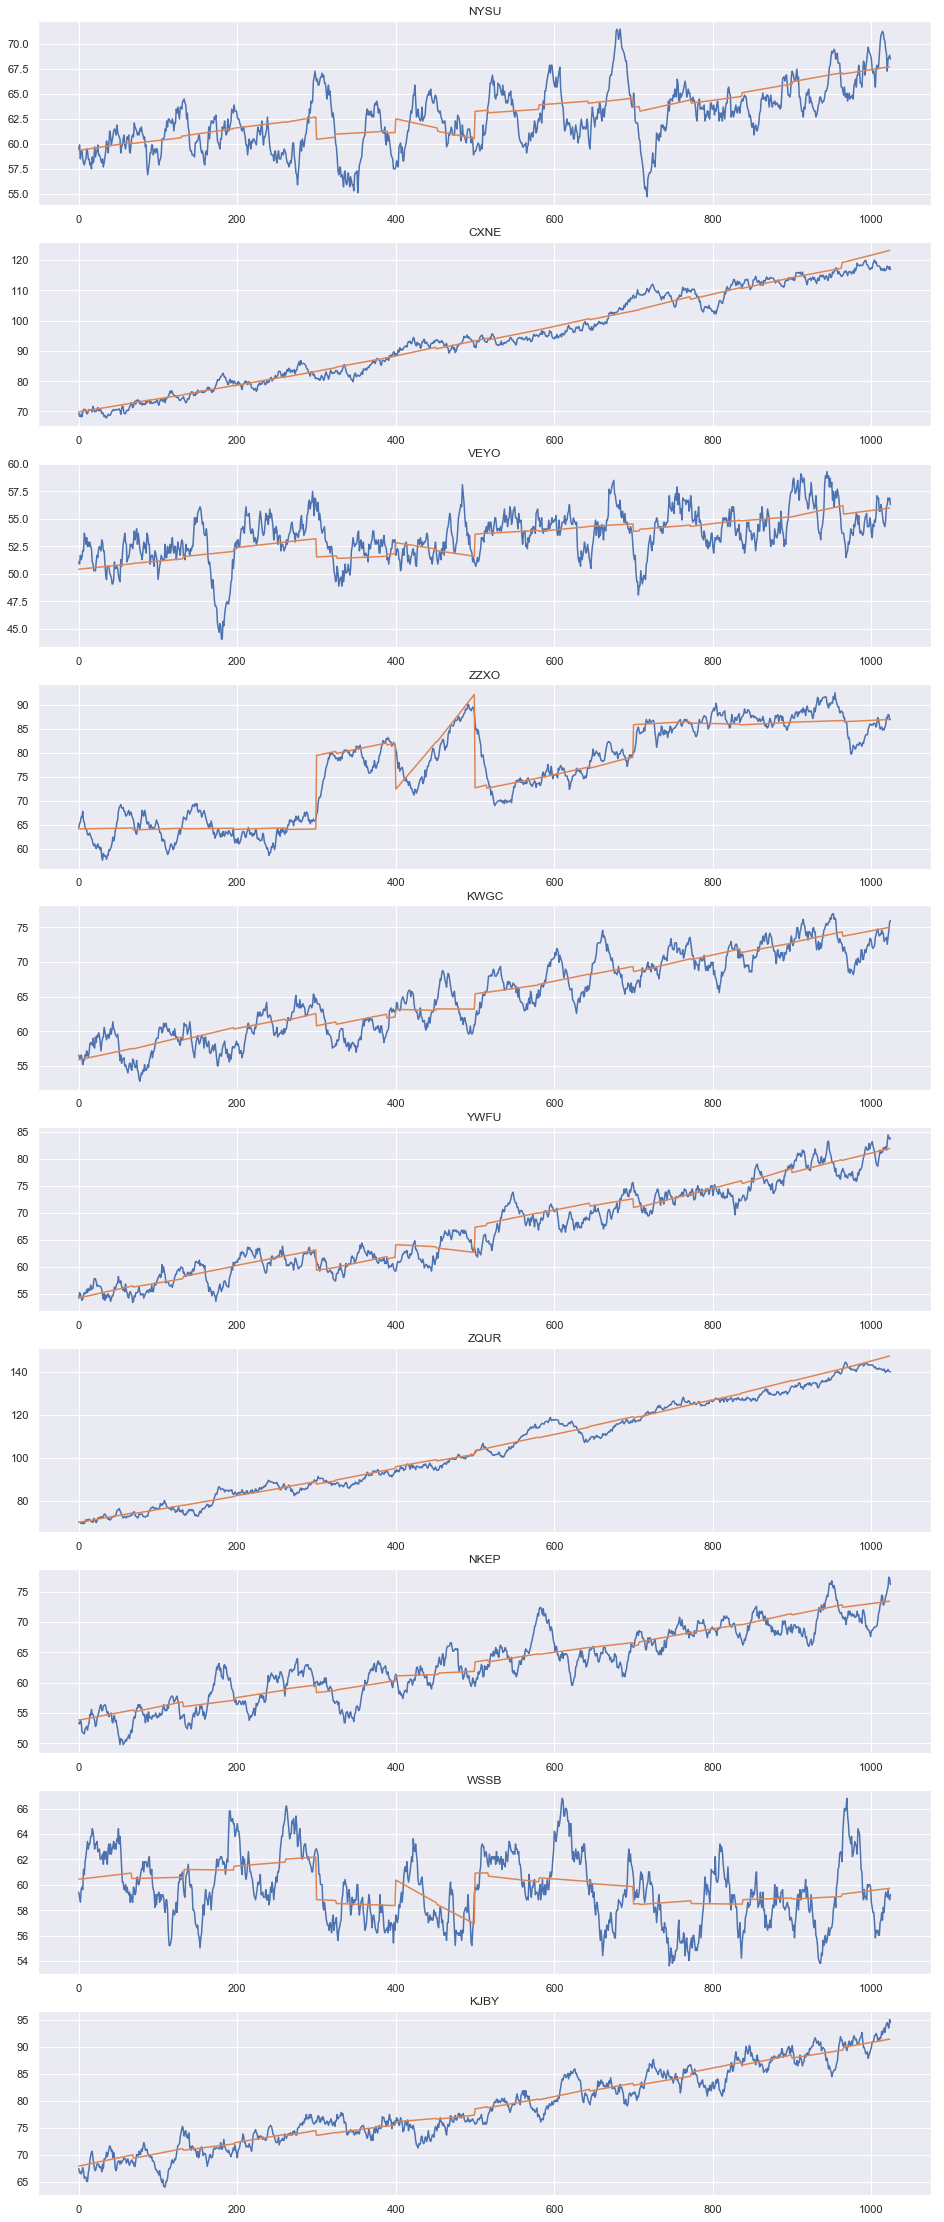

In [131]:
charts = [
    [
        [np.array(market.history[tickers[i]])[:,1]],
        [[stocks[i].psi(t) for t in range(period)]]
    ]
    for i in range(len(tickers))
]
plot_many(10,1,16,40, charts, titles=tickers);

In [132]:
N_STOCKS = 10

In [133]:
tickers = list(set(["".join([chr(int(np.random.random()*26+65)) for i in range(4)]) 
                    for i in range(2*N_STOCKS)]))[:N_STOCKS]

In [134]:
def save_a_package():
    for i in range(1):
        period = 1152
        stocks = {}
        for ticker in tickers:
            E_cagr = np.random.normal(3e-2, 2e-2)   # expected compound annual growth rate
            max_effect = 3.0 # Maximum overrating due to sentiment
            psi0 = 50 + 20 * np.random.random() # initial price
            sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
            beta_geo = np.random.normal(.0, .2)       # exposure (beta) to the US market
            stock = Stock(name=ticker, E_cagr=E_cagr, max_effect=max_effect, psi0 = psi0,
                            segments = {it: 1.0}, markets = {us: beta_geo},
                            sentiments = sentiments, noise=.4)
            stocks[ticker] = stock

        market = Market(stocks=list(stocks.values()), bid_ask=0.1)

        config = {
            'num_investors': 10,
            'num_rounds_per_day': 5
        }

        holdings = {ticker: 10000 for ticker in tickers}
        holdings['cash'] = 1e7

        environment = TradingEnvironment(config, holdings, market, tx_cost=2.5e-3)

        for _ in range(period):
            market.open()
            daily = environment.let_others_trade()
            market.close()

        package = [
            [np.array(market.history[ticker][:period])[:,1],
            [stocks[ticker].psi(t) for t in range(period)]]
            for ticker in tickers]

        with open('charts.pkl', 'ab') as file:
            pickle.dump(package, file)
            
#%time save_a_package()    

### Read the market data from the file system

In [135]:
data = []
with open('charts.pkl', 'rb') as file:
    while True:
        try: 
            data.append(pickle.load(file))
        except EOFError:
            break;
data = np.array(data)
data = data[:,:,0,:] # drop the intrinsic value

In [136]:
np.shape(data)

(3, 10, 1152)

In [137]:
class MarketFromData(StockMarket):
    """
    creates a market wrapper for an array or list of shape [N_STOCKS, N_PRICES]
    """
    def __init__(self, data, duration, nh, fee):
        """
        data: an array or list of shape [n_stocks, n_prices]
        nh: max. number of prices in history
        duration: the length of the period that can be served
        requires len(data) == duration + nh
        """
        self.duration = duration
        self.nh = nh
        self.data = np.array(data)
        self.n_securities = np.shape(self.data)[0]
        self.fee = fee
        length = np.shape(self.data)[1]
        if length != duration + nh:
            raise ValueError("record length not sum of duration and history.")
        # Need one more for the log returns
        np.append(self.data, self.data[:,-1:], axis = -1)
                    
    def log_return_history(self, nh, t):
        if t < 0 or t >= duration:
            raise ValueError("t must be between %s and %s" % (0, self.duration - 1))
        if nh > self.nh or nh <= 0:
            raise ValueError("t must be between %s and %s" % (1, self.nh))
        t += self.nh + 1
        
        h = self.data[ :, t-nh-1: t]
        return np.log(h[:, 1:] / h[:, :-1]).T
        
    def prices(self, t):
        return self.data[:, t]

In [138]:
market = MarketFromData(data[0], 1024, 128, fee=2.5e-3)

In [139]:
h = market.log_return_history(128, 0)
h[::64]

array([[ 0.01097304,  0.00975729, -0.00326227, -0.01269254,  0.00584549,
        -0.00647283,  0.        ,  0.01426497,  0.        , -0.00729584],
       [ 0.02021087,  0.00329528, -0.01589682,  0.00372232,  0.        ,
         0.        , -0.00673245, -0.00286932, -0.01408846, -0.00994604]])

In [140]:
market.prices(0)

array([54.38 , 61.193, 61.407, 63.43 , 68.229, 61.997, 54.814, 69.603,
       61.185, 55.026])

In [141]:
env = MarketEnvironment(
    market = market, 
    return_scale = 100,
    weight_scale = .1,
    n_hist = 128, 
    portfolio = [4e5, 3e5, 3e5],
    t_init = 0)

In [142]:
observation = env.step([.3, .2, .5])
observation

[(array([[ 0.01097304,  0.00975729, -0.00326227, ...,  0.01426497,
         0.        , -0.00729584],
       [ 0.00724904, -0.01303099, -0.00655665, ..., -0.00853454,
         0.0194228 ,  0.00729584],
       [ 0.00360491, -0.0098859 ,  0.0032837 , ...,  0.        ,
        -0.02598181,  0.01084492],
       ...,
       [ 0.02010792,  0.01090033, -0.01073221, ..., -0.00824147,
         0.01855197,  0.01303629],
       [ 0.01318411, -0.00271396,  0.02486497, ..., -0.00830995,
        -0.00306819, -0.02182254],
       [-0.00987175, -0.01093012, -0.00351451, ..., -0.01118846,
        -0.01860952,  0.00440277]]), array([0.4, 0.3, 0.3], dtype=float32)), array([0.3, 0.2, 0.5], dtype=float32), 0.007091129903407356, (array([[ 0.00724904, -0.01303099, -0.00655665, ..., -0.00853454,
         0.0194228 ,  0.00729584],
       [ 0.00360491, -0.0098859 ,  0.0032837 , ...,  0.        ,
        -0.02598181,  0.01084492],
       [-0.01085394,  0.00660145,  0.        , ..., -0.02020183,
        -0.003295

In [143]:
# Note that ```state()``` returns values scaled for training efficiency
state = env.state()[0]#[0]
np.shape(state)

(1, 128, 10, 1)

### Preprocessing the observations

There's a lot of noise in the daily log returns. We want to use 8-days averages instead. Let's look at one of the stocks.
```avg_over_axis(...)``` samples a given axis down. That's essentially average pooling in a single dimension. We could have done that with a neural network layer...;-)

In [144]:
means = avg_over_axis(state, axis=1, section=8)
means.shape

(1, 16, 10, 1)

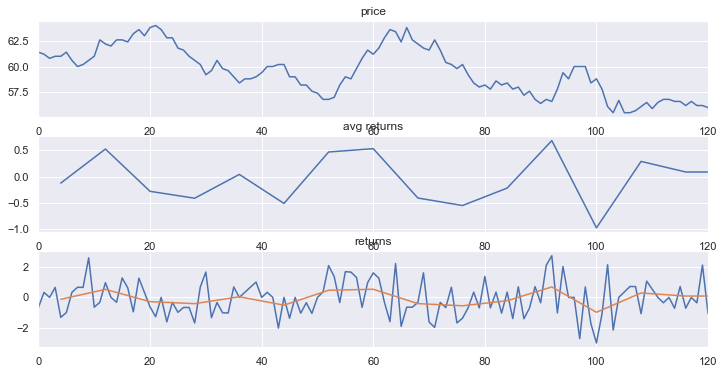

In [145]:
index = 2
test=state[0, :, index, 0]

# data  = [charts]
# chart = [curve]
# curve = [xy]
# xy = array(float) or xy = array(float), array(float)
single = np.squeeze(means).T[index]
charts = [
    [[data[0][index][:128]]],
    [[4+8*np.array(range(16)), single]],
    [
        [test],
        [4+8*np.array(range(16)), np.mean(test.reshape(16, 8), axis=-1)]
    ]
]
plot_many(3,1,12,6, charts, titles=['price', 'avg returns', 'returns'], xlim=(0, 120));